In [38]:
import datetime as dt
import numpy as np
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt

In [39]:
observation_date = observation_date = dt.datetime(year=2021, month=2, day=27)

FILE_NAMES = [
    "data/{td:%y}-{td:%m}-{td:%d}-ohlc".format(td=observation_date)
    ,
]

In [40]:
## TODO: Make this actually work for multiple files
for file in FILE_NAMES:
    with open(file, 'rb') as f:
        data = np.frombuffer(f.read()).reshape(-1, 5).copy()
        data[:,0] = list(map(lambda dtbytes: int.from_bytes(dtbytes, 'little'),data[:,0]))

In [41]:
df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)

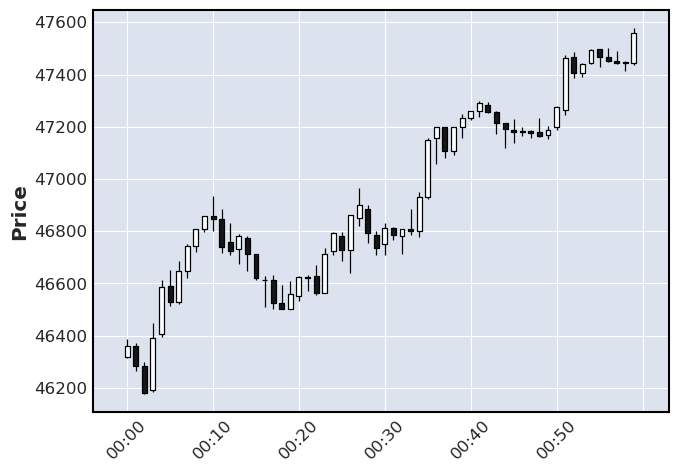

In [42]:
mpf.plot(df.set_index('timestamp')[:60], type='candle')

In [48]:
# Reshape into 4 channel timeseries
# Channels 0,1,2,3 = open, high, low, close
series = data.T[1:].reshape(4,1440)

# Normalize series between [0,1] (MinMaxScaler)
normed_series = np.empty(shape=(4,1440))
for idx, channel in enumerate(series):
    min_ = np.min(channel)
    max_ = np.max(channel)
    normed_channel = (channel - min_) / (max_ - min_)
    normed_series[idx] = normed_channel

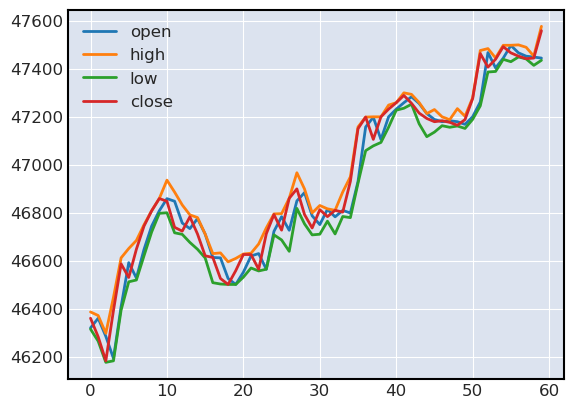

In [7]:
plt.plot(np.arange(0, len(sample[0])), sample[0], label="open")
plt.plot(np.arange(0, len(sample[1])), sample[1], label="high")
plt.plot(np.arange(0, len(sample[2])), sample[2], label="low")
plt.plot(np.arange(0, len(sample[3])), sample[3], label="close")
plt.legend()

In [88]:
sample = normed_series.T[:60].T

(0.0, 1.0)

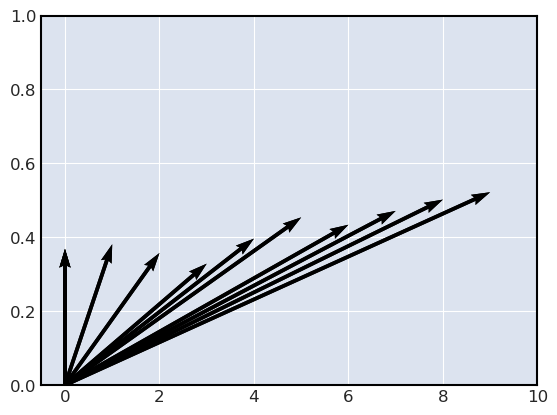

In [89]:
origin = [0,0]
X, Y = zip(origin, origin)
data = np.array([0, sample[0][0]])
ax = plt.subplot(111)
for i in range(10):
    vec = np.array([i, sample[0][i]])
    ax.quiver(X, Y, *vec, angles='xy', scale_units='xy', scale=1)
    
ax.quiver(X, Y, *data,angles='xy', scale_units='xy', scale=1)
ax.set_xlim(-0.5,10)
ax.set_ylim(0, 1)

In [101]:
polar_sample = np.arccos(sample.T).T
r = np.arange(0, 1, 1/len(polar_sample[0]) )

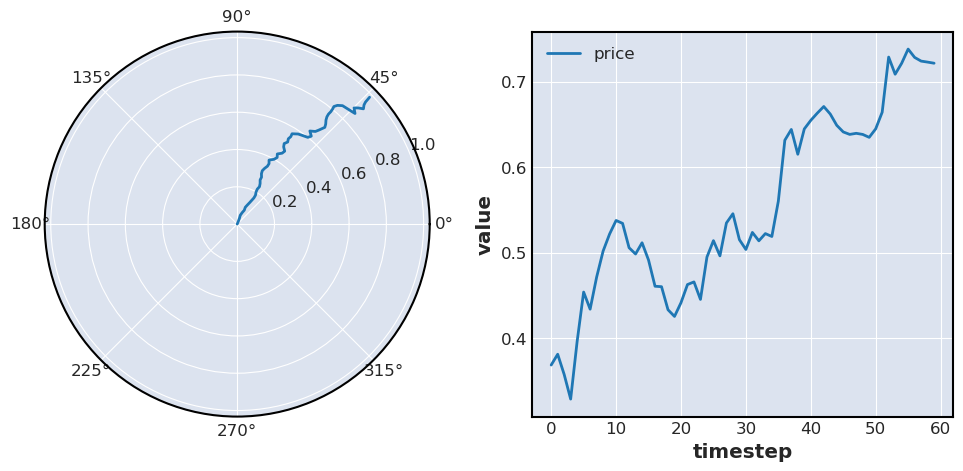

In [147]:
fig = plt.figure(figsize=(25,5))
axp = fig.add_subplot(141, projection='polar')
axp.plot(polar_sample[0], r, label="price")
axc = fig.add_subplot(142, projection='rectilinear')
axc.plot(np.arange(0, len(sample[0])), sample[0], label="price")
axc.set_xlabel("timestep")
axc.set_ylabel('value')
plt.legend()
plt.show()